In [7]:

import numpy as np
import pandas as pd
from scripts.unsupervised_utils.filter_by_noise_ratio import filter_by_noise_ratio
from scripts.unsupervised_utils.paretos import extract_pareto_front
from scripts.Training.unsupervised.grid_search_hdbscan import run_hdbscan_grid
from scripts.Training.unsupervised.grid_search_knn import run_kmeans_grid
from scripts.Training.unsupervised.run_hdbscan_combinaison import  run_hdbscan_combinations
from scripts.Training.unsupervised.grid_search_clarans import run_clarans_grid
from scripts.Training.unsupervised.run_algo import kmeans_with_map , hdbscan_with_map
from scripts.utils.remove_desert import save_shapefile_north_of_latitude

output_shapefile_path = "../data/shapefiles/combined/north/north.shp"


save_shapefile_north_of_latitude(
    input_shapefile_path="../data/shapefiles/combined/full/",
    output_shapefile_path=output_shapefile_path,
    latitude_cut=34.0,
)


✅ Shapefile saved:
   ../data/shapefiles/combined/north/north.shp
   (North of latitude 34.0)


,GID_0,COUNTRY,geometry
0,DZA,Algeria,"MULTIPOLYGON (((2.84413 36.74151, 2.84535 36.7..."
1,TUN,Tunisia,"MULTIPOLYGON (((7.55636 34.00558, 7.5602 34.01..."


## Load data

In [8]:

# -----------------------------
# 1. Load your data
# -----------------------------
data_path_32 = "../data/preprocessed/preprocessed_reduced_unsupervised_32.csv"
X_data_32 = pd.read_csv(data_path_32)



data_path_10 = "../data/preprocessed/preprocessed_reduced_unsupervised_10.csv"
X_data_10 = pd.read_csv(data_path_10)

shapefile_path = "../data/shapefiles/combined/north/north.shp"

print("Data shape after sampling (k-mean):", X_data_32.shape)
print("Data shape after sampling (dbscan):", X_data_10.shape)

Data shape after sampling (k-mean): (735483, 33)
Data shape after sampling (dbscan): (735483, 10)


## K-mean

In [21]:
results = run_kmeans_grid(
    X=X_data_32,
    k_values=list(range(3, 51)),  # 3,5,7,...,49
    output_path="./results/knn_metrics.csv",
    algorithm="minibatch_kmeans",  
    batch_size=4096,
    metrics=("ch", "dbi","wcss"),
)



minibatch_kmeans Grid Search: 100%|██████████| 48/48 [02:12<00:00,  2.76s/it]


In [ ]:
pareto = extract_pareto_front(
    csv_path="./results/knn_metrics.csv",
    metrics=["CH", "DBI"],
)

print(pareto)

    K       init         algorithm             CH       DBI  WCSS_per_point
0   3  k-means++  minibatch_kmeans  254988.834430  1.721380       16.684688
1   5  k-means++  minibatch_kmeans  180414.047959  1.701579       14.263527
2   8  k-means++  minibatch_kmeans  147410.138872  1.512309       11.756861
3  11  k-means++  minibatch_kmeans  126335.821244  1.505054       10.413611
4  12  k-means++  minibatch_kmeans  125704.384579  1.368123        9.811640
5  13  k-means++  minibatch_kmeans  124980.671951  1.341546        9.296829
6  14  k-means++  minibatch_kmeans  120858.929637  1.329219        9.021307
7  16  k-means++  minibatch_kmeans  115956.241494  1.277816        8.403590
8  21  k-means++  minibatch_kmeans  117611.923318  1.288624        6.730543
9  26  k-means++  minibatch_kmeans  110334.797442  1.211595        5.948190


In [32]:
results = run_kmeans_grid(
    X=X_data_32,
    k_values=[3,5,8,11,12,14,16,21,26],  # 3,5,7,...,49
    n_init=10,
    output_path="./results/knn_silhouette.csv",
    algorithm="minibatch_kmeans",  
    batch_size=4096,
    metrics=("silhouette"),
)


minibatch_kmeans Grid Search: 100%|██████████| 9/9 [55:06<00:00, 367.38s/it]


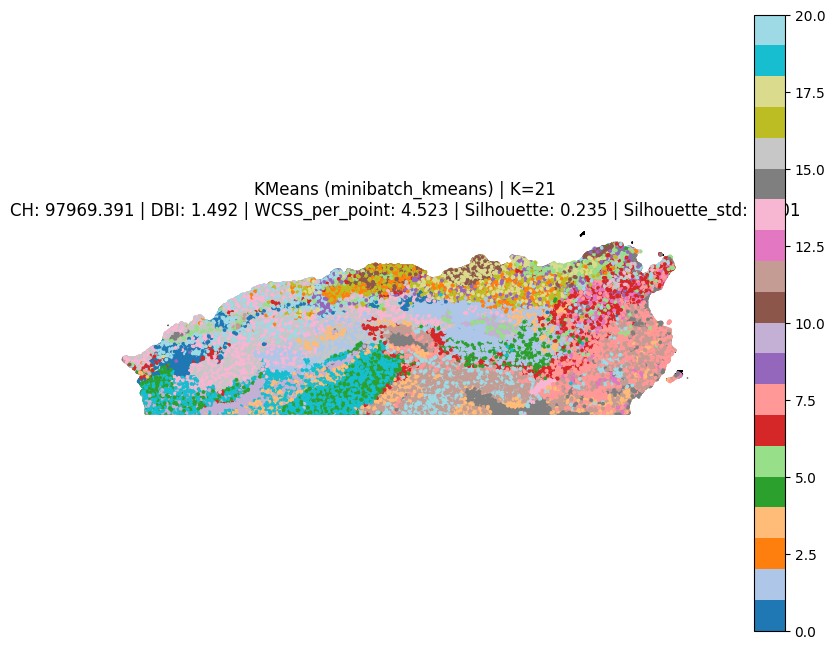

In [9]:
gdf_km, km_metrics = kmeans_with_map(
    df=X_data_32,
    shapefile_path=shapefile_path,
    k_value=21,
    algorithm="minibatch_kmeans",

)

## HDBSCAN 

In [ ]:
results = run_hdbscan_grid(
    X=X_data_10,
    min_cluster_sizes=[50, 100, 200, 500, 1000],
    min_samples_values=[5, 10, 20, 50],
    output_path="./results/hdbscan_results.csv",
    metrics=("ch", "dbi", "wcss"),
)


HDBSCAN Grid Search:   5%|▌         | 1/20 [09:51<3:07:26, 591.90s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 5, 'n_clusters': 4896, 'n_noise': np.int64(132861), 'noise_ratio': np.float64(0.18064455602644794), 'CH': 9171.463955278918, 'DBI': 0.8613381514160154, 'WCSS': ae_feature_0    1904.976222
ae_feature_1    2187.019630
ae_feature_2    2610.673438
ae_feature_3    1770.657166
ae_feature_4    1794.338724
ae_feature_5    2028.925024
ae_feature_6    1534.773417
ae_feature_7    1365.848959
ae_feature_8    3307.210763
ae_feature_9    1770.328046
dtype: float64}


HDBSCAN Grid Search:  10%|█         | 2/20 [19:08<2:51:24, 571.36s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 10, 'n_clusters': 4705, 'n_noise': np.int64(141521), 'noise_ratio': np.float64(0.19241913137353275), 'CH': 9613.115812421172, 'DBI': 0.8402605206507678, 'WCSS': ae_feature_0    1637.425615
ae_feature_1    2211.965408
ae_feature_2    2542.972394
ae_feature_3    1769.443822
ae_feature_4    1698.391460
ae_feature_5    2122.254359
ae_feature_6    1459.864554
ae_feature_7    1353.819022
ae_feature_8    3033.734207
ae_feature_9    1665.027780
dtype: float64}


HDBSCAN Grid Search:  15%|█▌        | 3/20 [28:13<2:38:23, 559.06s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 20, 'n_clusters': 4348, 'n_noise': np.int64(164588), 'noise_ratio': np.float64(0.2237821948297921), 'CH': 10901.939547762211, 'DBI': 0.7858744066065787, 'WCSS': ae_feature_0    1311.279903
ae_feature_1    2042.126547
ae_feature_2    2304.419526
ae_feature_3    1639.257572
ae_feature_4    1416.645972
ae_feature_5    1808.275445
ae_feature_6    1285.162150
ae_feature_7    1195.780749
ae_feature_8    2810.135014
ae_feature_9    1408.050353
dtype: float64}


HDBSCAN Grid Search:  20%|██        | 4/20 [33:25<2:03:03, 461.46s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 50, 'n_clusters': 2817, 'n_noise': np.int64(205932), 'noise_ratio': np.float64(0.27999559473162533), 'CH': 11404.679120484165, 'DBI': 0.7131264394375787, 'WCSS': ae_feature_0    1446.083768
ae_feature_1    2822.704816
ae_feature_2    3140.337292
ae_feature_3    2446.752774
ae_feature_4    1672.456282
ae_feature_5    2257.644770
ae_feature_6    1454.121199
ae_feature_7    1539.360471
ae_feature_8    3413.806977
ae_feature_9    1684.746211
dtype: float64}


HDBSCAN Grid Search:  25%|██▌       | 5/20 [37:49<1:37:34, 390.31s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 5, 'n_clusters': 1817, 'n_noise': np.int64(107569), 'noise_ratio': np.float64(0.14625626968944216), 'CH': 11220.06161127598, 'DBI': 1.0447686624851438, 'WCSS': ae_feature_0    3656.902318
ae_feature_1    5955.956548
ae_feature_2    7084.562907
ae_feature_3    4630.062525
ae_feature_4    4010.296643
ae_feature_5    4969.147300
ae_feature_6    3324.838880
ae_feature_7    2888.743519
ae_feature_8    7083.710121
ae_feature_9    3946.680020
dtype: float64}


HDBSCAN Grid Search:  30%|███       | 6/20 [42:21<1:21:42, 350.18s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 10, 'n_clusters': 1603, 'n_noise': np.int64(101255), 'noise_ratio': np.float64(0.13767143496178702), 'CH': 10337.616303649264, 'DBI': 1.0471441211718502, 'WCSS': ae_feature_0    3875.780241
ae_feature_1    9114.425265
ae_feature_2    9505.378473
ae_feature_3    6578.004698
ae_feature_4    4442.908176
ae_feature_5    6080.397838
ae_feature_6    3596.598363
ae_feature_7    3266.115467
ae_feature_8    7961.603214
ae_feature_9    4487.454255
dtype: float64}


HDBSCAN Grid Search:  35%|███▌      | 7/20 [46:59<1:10:44, 326.48s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 20, 'n_clusters': 1482, 'n_noise': np.int64(110475), 'noise_ratio': np.float64(0.1502074147193069), 'CH': 10828.90538858892, 'DBI': 1.0131244363516427, 'WCSS': ae_feature_0    3586.702142
ae_feature_1    9298.645199
ae_feature_2    9812.105168
ae_feature_3    6712.461031
ae_feature_4    4212.477135
ae_feature_5    6026.491122
ae_feature_6    3407.928910
ae_feature_7    3183.378224
ae_feature_8    8172.297760
ae_feature_9    4307.494234
dtype: float64}


HDBSCAN Grid Search:  40%|████      | 8/20 [51:55<1:03:23, 316.95s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 50, 'n_clusters': 1117, 'n_noise': np.int64(133634), 'noise_ratio': np.float64(0.1816955660429949), 'CH': 12354.581972751314, 'DBI': 0.9555195940977038, 'WCSS': ae_feature_0     3635.086677
ae_feature_1     9760.653718
ae_feature_2    11454.281453
ae_feature_3     7224.402862
ae_feature_4     4524.496049
ae_feature_5     6734.028462
ae_feature_6     3473.879529
ae_feature_7     3416.516728
ae_feature_8     8322.031815
ae_feature_9     4600.600309
dtype: float64}


HDBSCAN Grid Search:  45%|████▌     | 9/20 [56:14<54:47, 298.86s/it]  

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 5, 'n_clusters': 743, 'n_noise': np.int64(84125), 'noise_ratio': np.float64(0.11438061790687208), 'CH': 14732.085831867687, 'DBI': 1.246674383919357, 'WCSS': ae_feature_0     6457.569773
ae_feature_1    14017.030413
ae_feature_2    15325.860308
ae_feature_3     9399.449346
ae_feature_4     6716.730094
ae_feature_5     9425.904977
ae_feature_6     5410.555842
ae_feature_7     4947.423230
ae_feature_8    12931.692165
ae_feature_9     7138.556696
dtype: float64}


HDBSCAN Grid Search:  50%|█████     | 10/20 [1:00:40<48:04, 288.44s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 10, 'n_clusters': 668, 'n_noise': np.int64(77475), 'noise_ratio': np.float64(0.1053389405329559), 'CH': 15382.296571852172, 'DBI': 1.2270765132152626, 'WCSS': ae_feature_0     6575.143712
ae_feature_1    15601.337216
ae_feature_2    17395.932697
ae_feature_3    10649.586866
ae_feature_4     6950.999766
ae_feature_5    10127.724371
ae_feature_6     5844.294255
ae_feature_7     5000.959634
ae_feature_8    13047.569238
ae_feature_9     7239.238511
dtype: float64}


HDBSCAN Grid Search:  55%|█████▌    | 11/20 [1:05:10<42:26, 283.00s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 20, 'n_clusters': 661, 'n_noise': np.int64(88982), 'noise_ratio': np.float64(0.1209844415166632), 'CH': 15974.81674241059, 'DBI': 1.205005259036342, 'WCSS': ae_feature_0     5706.535737
ae_feature_1    15153.357658
ae_feature_2    16373.356998
ae_feature_3    10236.324939
ae_feature_4     6423.476755
ae_feature_5     9849.889824
ae_feature_6     5230.802069
ae_feature_7     4699.499722
ae_feature_8    11821.524223
ae_feature_9     6825.573433
dtype: float64}


HDBSCAN Grid Search:  60%|██████    | 12/20 [1:10:03<38:08, 286.01s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 50, 'n_clusters': 550, 'n_noise': np.int64(97745), 'noise_ratio': np.float64(0.13289906088923878), 'CH': 15464.683692850305, 'DBI': 1.1185523937460142, 'WCSS': ae_feature_0     6404.609136
ae_feature_1    18469.376503
ae_feature_2    18267.874350
ae_feature_3    10908.612957
ae_feature_4     7918.678864
ae_feature_5    12836.302768
ae_feature_6     5513.250836
ae_feature_7     6993.228049
ae_feature_8    13555.702426
ae_feature_9     8743.009087
dtype: float64}


HDBSCAN Grid Search:  65%|██████▌   | 13/20 [1:21:02<46:31, 398.84s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 5, 'n_clusters': 333, 'n_noise': np.int64(72849), 'noise_ratio': np.float64(0.09904919624246923), 'CH': 19520.458469499044, 'DBI': 1.477029953709076, 'WCSS': ae_feature_0    13038.453805
ae_feature_1    23653.843157
ae_feature_2    23237.422425
ae_feature_3    13774.557384
ae_feature_4    11251.490018
ae_feature_5    16367.776090
ae_feature_6     8334.965611
ae_feature_7     9363.046942
ae_feature_8    20017.138628
ae_feature_9    13147.369468
dtype: float64}


HDBSCAN Grid Search:  70%|███████   | 14/20 [1:25:10<35:20, 353.42s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 10, 'n_clusters': 304, 'n_noise': np.int64(71311), 'noise_ratio': np.float64(0.09695805341523869), 'CH': 20098.32679103336, 'DBI': 1.4504874849050242, 'WCSS': ae_feature_0    12838.252534
ae_feature_1    26325.195751
ae_feature_2    24895.832748
ae_feature_3    14498.565355
ae_feature_4    11662.955407
ae_feature_5    17160.633329
ae_feature_6     8326.301381
ae_feature_7     9622.504609
ae_feature_8    21647.030706
ae_feature_9    13737.684811
dtype: float64}


HDBSCAN Grid Search:  75%|███████▌  | 15/20 [1:29:26<26:59, 323.97s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 20, 'n_clusters': 299, 'n_noise': np.int64(78395), 'noise_ratio': np.float64(0.10658981920724205), 'CH': 21257.88444829589, 'DBI': 1.4295759292641526, 'WCSS': ae_feature_0    11083.316018
ae_feature_1    25161.507960
ae_feature_2    23876.961337
ae_feature_3    14627.064010
ae_feature_4    11179.492839
ae_feature_5    16695.648385
ae_feature_6     7787.950011
ae_feature_7     9122.799122
ae_feature_8    19485.112736
ae_feature_9    12658.696097
dtype: float64}


HDBSCAN Grid Search:  80%|████████  | 16/20 [1:34:04<20:40, 310.11s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 50, 'n_clusters': 295, 'n_noise': np.int64(93779), 'noise_ratio': np.float64(0.12750668608247914), 'CH': 24703.715102483402, 'DBI': 1.3340416980474894, 'WCSS': ae_feature_0     8497.584769
ae_feature_1    20896.331823
ae_feature_2    21618.992030
ae_feature_3    13235.736254
ae_feature_4     9497.693498
ae_feature_5    14035.099793
ae_feature_6     6375.687808
ae_feature_7     7454.417119
ae_feature_8    16047.876930
ae_feature_9     9439.066311
dtype: float64}


HDBSCAN Grid Search:  85%|████████▌ | 17/20 [1:38:05<14:28, 289.48s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 5, 'n_clusters': 191, 'n_noise': np.int64(80860), 'noise_ratio': np.float64(0.10994135826388918), 'CH': 25034.36931778628, 'DBI': 1.6094857989036444, 'WCSS': ae_feature_0    19098.750516
ae_feature_1    30928.553817
ae_feature_2    26569.637610
ae_feature_3    16020.833030
ae_feature_4    15681.987726
ae_feature_5    20884.901957
ae_feature_6    11353.114853
ae_feature_7    12532.831467
ae_feature_8    23630.781867
ae_feature_9    18474.050619
dtype: float64}


HDBSCAN Grid Search:  90%|█████████ | 18/20 [1:42:13<09:13, 276.99s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 10, 'n_clusters': 186, 'n_noise': np.int64(87669), 'noise_ratio': np.float64(0.1191992201043396), 'CH': 27565.36467344073, 'DBI': 1.6213186785981404, 'WCSS': ae_feature_0    16371.552735
ae_feature_1    27906.379734
ae_feature_2    26935.896712
ae_feature_3    16226.320915
ae_feature_4    14295.305269
ae_feature_5    18406.904630
ae_feature_6    10432.204091
ae_feature_7    10395.578268
ae_feature_8    22010.647658
ae_feature_9    15433.984887
dtype: float64}


HDBSCAN Grid Search:  95%|█████████▌| 19/20 [1:46:25<04:29, 269.51s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 20, 'n_clusters': 185, 'n_noise': np.int64(95088), 'noise_ratio': np.float64(0.12928646889187106), 'CH': 27930.08263966517, 'DBI': 1.5998466732280687, 'WCSS': ae_feature_0    15918.056955
ae_feature_1    27357.436802
ae_feature_2    26526.519074
ae_feature_3    15814.317662
ae_feature_4    13712.543237
ae_feature_5    18114.901448
ae_feature_6     9444.075308
ae_feature_7    10147.271740
ae_feature_8    21119.397391
ae_feature_9    14702.237520
dtype: float64}


HDBSCAN Grid Search: 100%|██████████| 20/20 [1:50:58<00:00, 332.92s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 50, 'n_clusters': 174, 'n_noise': np.int64(107191), 'noise_ratio': np.float64(0.1457423217123985), 'CH': 29329.604730543622, 'DBI': 1.4589200360601353, 'WCSS': ae_feature_0    14375.044213
ae_feature_1    27391.152312
ae_feature_2    25517.505758
ae_feature_3    15262.104495
ae_feature_4    13019.377237
ae_feature_5    17882.186885
ae_feature_6     7959.508951
ae_feature_7    10431.774058
ae_feature_8    21287.833577
ae_feature_9    13197.291996
dtype: float64}


In [5]:
filter_by_noise_ratio("./results/hdbscan_results.csv","./results/hdbscan_results_filtered.csv",min_noise_ratio=0.2)

Saved 18 / 20 rows to ./results/hdbscan_results_filtered.csv


In [8]:
pareto = extract_pareto_front(
    csv_path="./results/hdbscan_results_filtered.csv",
    metrics=["CH", "DBI"],
)

print(pareto)

  algorithm  min_cluster_sizes  min_samples  n_clusters  n_noise  noise_ratio  \
0   hdbscan                 50           10        4705   141521     0.192419   
1   hdbscan                100           50        1117   133634     0.181696   
2   hdbscan                200           20         661    88982     0.120984   
3   hdbscan                200           50         550    97745     0.132899   
4   hdbscan                500           50         295    93779     0.127507   
5   hdbscan               1000           50         174   107191     0.145742   

             CH       DBI  
0   9613.115812  0.840261  
1  12354.581973  0.955520  
2  15974.816742  1.205005  
3  15464.683693  1.118552  
4  24703.715102  1.334042  
5  29329.604731  1.458920  


In [ ]:
param_combinations = [
    {"min_cluster_size": 50, "min_samples": 10},
    {"min_cluster_size": 100, "min_samples": 50},
    {"min_cluster_size": 200, "min_samples": 20},
    {"min_cluster_size": 200, "min_samples": 50},
    {"min_cluster_size": 500, "min_samples": 50},
    {"min_cluster_size": 1000, "min_samples": 50},
    
]

df = run_hdbscan_combinations(
    X=X_data_10,
    param_combinations=param_combinations,
    output_path="./results/hdbscan_selected_runs.csv",
    metrics=("ch", "dbi","silhouette"),
)


HDBSCAN Runs:  17%|█▋        | 1/6 [12:31<1:02:36, 751.36s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 50, 'min_samples': 10, 'n_clusters': 4705, 'n_noise': np.int64(141521), 'noise_ratio': np.float64(0.19241913137353275), 'CH': 9613.115812421172, 'DBI': 0.8402605206507678, 'Silhouette': np.float64(0.415047631999162), 'Silhouette_std': np.float64(0.0012099766964917239)}


HDBSCAN Runs:  33%|███▎      | 2/6 [21:20<41:23, 620.80s/it]  

{'algorithm': 'hdbscan', 'min_cluster_size': 100, 'min_samples': 50, 'n_clusters': 1117, 'n_noise': np.int64(133634), 'noise_ratio': np.float64(0.1816955660429949), 'CH': 12354.581972751314, 'DBI': 0.9555195940977038, 'Silhouette': np.float64(0.24981478331024148), 'Silhouette_std': np.float64(0.001807645142020548)}


HDBSCAN Runs:  50%|█████     | 3/6 [29:19<27:47, 555.78s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 20, 'n_clusters': 661, 'n_noise': np.int64(88982), 'noise_ratio': np.float64(0.1209844415166632), 'CH': 15974.81674241059, 'DBI': 1.205005259036342, 'Silhouette': np.float64(0.21911689986108668), 'Silhouette_std': np.float64(0.001626174528131428)}


d:\usthb\M2\DataMining\projet\DataMining--Project\DMenv\lib\site-packages\joblib\externals\loky\process_executor.py:782: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
HDBSCAN Runs:  67%|██████▋   | 4/6 [37:17<17:30, 525.14s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 200, 'min_samples': 50, 'n_clusters': 550, 'n_noise': np.int64(97745), 'noise_ratio': np.float64(0.13289906088923878), 'CH': 15464.683692850305, 'DBI': 1.1185523937460142, 'Silhouette': np.float64(0.22099316894987764), 'Silhouette_std': np.float64(0.0016330261896091833)}


HDBSCAN Runs:  83%|████████▎ | 5/6 [44:55<08:20, 500.89s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 500, 'min_samples': 50, 'n_clusters': 295, 'n_noise': np.int64(93779), 'noise_ratio': np.float64(0.12750668608247914), 'CH': 24703.715102483402, 'DBI': 1.3340416980474894, 'Silhouette': np.float64(0.22021246746883166), 'Silhouette_std': np.float64(0.0010693207788540038)}


HDBSCAN Runs: 100%|██████████| 6/6 [52:35<00:00, 526.00s/it]

{'algorithm': 'hdbscan', 'min_cluster_size': 1000, 'min_samples': 50, 'n_clusters': 174, 'n_noise': np.int64(107191), 'noise_ratio': np.float64(0.1457423217123985), 'CH': 29329.604730543622, 'DBI': 1.4589200360601353, 'Silhouette': np.float64(0.20762483780073993), 'Silhouette_std': np.float64(0.001571614176482901)}


In [ ]:
gdf_hdb, hdb_metrics = hdbscan_with_map(
    df=X_data_10,
    shapefile_path="algeria_regions.shp",
    min_cluster_size=300,
    min_samples=50,
)

## Clarans

In [ ]:
results = run_clarans_grid(
    X=X_data_32.values,
    k_values=range(3, 21, 2),
    numlocal_values=[3, 5],
    maxneighbor_values=[20, 50],
    output_path="./results/clarans_results.csv",
    metrics=("ch", "dbi", "avg_medoid_dist"),
)


CLARANS Grid Search:   0%|          | 0/36 [00:00<?, ?it/s]